In [1]:
# ------------------------------------------------------------
# Step 1 · Imports and Paths
# ------------------------------------------------------------
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
import matplotlib.pyplot as plt

# File paths
base_path = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/processed")
csv_age_fp = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/raw/continuous_age/lsoa_age_by_year_total_2024.csv")
gpkg_fp = base_path / "lsoa_south_west_enriched.gpkg"  # Using this for MSOA geometry


In [3]:
# ------------------------------------------------------------
# Step 2 · Load Files
# ------------------------------------------------------------
df_age = pd.read_csv(csv_age_fp)
gdf_lsoa = gpd.read_file(gpkg_fp)

print(f"[Age CSV] Rows: {df_age.shape[0]}, Columns: {df_age.shape[1]}")
print(f"[Age CSV] Columns: {list(df_age.columns)}")  # <-- Added column name check
print(f"[LSOA GPKG] Rows: {gdf_lsoa.shape[0]}, Columns: {gdf_lsoa.shape[1]}")
print(f"CRS of GPKG: {gdf_lsoa.crs}")


[Age CSV] Rows: 3472, Columns: 92
[Age CSV] Columns: ['lsoa_code', 'lsoa_name', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89']
[LSOA GPKG] Rows: 3472, Columns: 16
CRS of GPKG: EPSG:27700


In [4]:
# ------------------------------------------------------------
# Step 3 · Fix Invalid Geometry in LSOA GPKG
# ------------------------------------------------------------
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection

def extract_valid_geom(geom):
    if isinstance(geom, (Polygon, MultiPolygon)):
        return geom
    elif isinstance(geom, GeometryCollection):
        # Extract first Polygon or MultiPolygon from collection if exists
        polys = [g for g in geom.geoms if isinstance(g, (Polygon, MultiPolygon))]
        return polys[0] if polys else None
    else:
        return None

# Apply cleaning function to geometry column
gdf_lsoa["geometry"] = gdf_lsoa["geometry"].apply(extract_valid_geom)

# Filter out rows with invalid geometry
gdf_lsoa = gdf_lsoa[gdf_lsoa["geometry"].notnull()].copy()

print(f"Geometry cleaned. Remaining valid geometries: {len(gdf_lsoa)}")


Geometry cleaned. Remaining valid geometries: 3451


In [5]:
# ------------------------------------------------------------
# Step 4 · Prepare Age CSV (Already Wide Format by LSOA)
# ------------------------------------------------------------

# Step 4a · Strip whitespace in string columns
df_age["lsoa_code"] = df_age["lsoa_code"].str.strip()
df_age["lsoa_name"] = df_age["lsoa_name"].str.strip()

# Step 4b · Confirm age columns are all treated as strings (optional check/fix)
df_age.columns = ["lsoa_code", "lsoa_name"] + [str(col) for col in df_age.columns[2:]]

# Step 4c · Print summary
print(f"Age DataFrame (wide) shape: {df_age.shape}")
print(df_age.head(2))


Age DataFrame (wide) shape: (3472, 92)
   lsoa_code           lsoa_name     0      1      2      3      4      5  \
0  E01014014  Herefordshire 018C  9.19  10.21  13.27  13.27  16.34  13.27   
1  E01014031  Herefordshire 023A  7.15   8.17  12.25  11.23   8.17  11.23   

       6      7  ...     80     81     82     83     84     85     86     87  \
0   8.17  12.25  ...  13.27  13.27  12.25  17.36   7.15   5.11   6.13   2.04   
1  12.25  14.30  ...  20.42  14.30   8.17  12.25  13.27  10.21  10.21  10.21   

     88    89  
0  8.17  6.13  
1  6.13  4.08  

[2 rows x 92 columns]


In [6]:
# ------------------------------------------------------------
# Step 5 · Join Age Data to LSOA GeoDataFrame
# ------------------------------------------------------------

# Optional: check GeoDataFrame LSOA code column
print(gdf_lsoa.columns)  # Confirm if it's 'lsoa21cd' or 'lsoa_code'

# Perform left join
gdf_lsoa_age = gdf_lsoa.merge(
    df_age,
    how="left",
    left_on="lsoa21cd",  # or 'lsoa_code' if same
    right_on="lsoa_code"
)

print(f"Joined GeoDataFrame shape: {gdf_lsoa_age.shape}")
print(gdf_lsoa_age.head(2))


Index(['lsoa21cd', 'lsoa21nm_x', 'lsoa21nmw', 'bng_e', 'bng_n', 'lat', 'long',
       'shape__are', 'shape__len', 'globalid', 'lsoa21nm_y', 'msoa21cd',
       'msoa21nm', 'ladcd', 'ladnm', 'geometry'],
      dtype='object')
Joined GeoDataFrame shape: (3451, 108)
    lsoa21cd          lsoa21nm_x lsoa21nmw   bng_e   bng_n       lat     long  \
0  E01014014  Herefordshire 018C      None  363652  243381  52.08759 -2.53190   
1  E01014031  Herefordshire 023A      None  354699  217612  51.85525 -2.65915   

     shape__are    shape__len                              globalid  ...  \
0  5.488187e+07  58635.757515  8fce111a-0aab-4f99-8777-1ed10d8b04b0  ...   
1  1.949198e+07  28805.195706  77655486-1b21-4c99-a981-4f2fdb43ed95  ...   

      80     81     82     83     84     85     86     87    88    89  
0  13.27  13.27  12.25  17.36   7.15   5.11   6.13   2.04  8.17  6.13  
1  20.42  14.30   8.17  12.25  13.27  10.21  10.21  10.21  6.13  4.08  

[2 rows x 108 columns]


In [8]:
# ------------------------------------------------------------
# Step 5a · Inspect Merged Output
# ------------------------------------------------------------

print(f"\nJoined GeoDataFrame shape: {gdf_lsoa_age.shape}")

# Check column names
print("\nColumns in joined GeoDataFrame:")
for col in gdf_lsoa_age.columns:
    print(f" - {col}")

# Check for duplicated columns
duplicates = gdf_lsoa_age.columns[gdf_lsoa_age.columns.duplicated()]
if duplicates.any():
    print(f"\nDuplicated columns detected: {duplicates.tolist()}")
else:
    print("\nNo duplicated columns in the merged GeoDataFrame.")

# Preview top rows
print("\nPreview of merged GeoDataFrame (first 2 rows):")
print(gdf_lsoa_age.head(2).to_string(index=False))


Joined GeoDataFrame shape: (3451, 108)

Columns in joined GeoDataFrame:
 - lsoa21cd
 - lsoa21nm_x
 - lsoa21nmw
 - bng_e
 - bng_n
 - lat
 - long
 - shape__are
 - shape__len
 - globalid
 - lsoa21nm_y
 - msoa21cd
 - msoa21nm
 - ladcd
 - ladnm
 - geometry
 - lsoa_code
 - lsoa_name
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
 - 8
 - 9
 - 10
 - 11
 - 12
 - 13
 - 14
 - 15
 - 16
 - 17
 - 18
 - 19
 - 20
 - 21
 - 22
 - 23
 - 24
 - 25
 - 26
 - 27
 - 28
 - 29
 - 30
 - 31
 - 32
 - 33
 - 34
 - 35
 - 36
 - 37
 - 38
 - 39
 - 40
 - 41
 - 42
 - 43
 - 44
 - 45
 - 46
 - 47
 - 48
 - 49
 - 50
 - 51
 - 52
 - 53
 - 54
 - 55
 - 56
 - 57
 - 58
 - 59
 - 60
 - 61
 - 62
 - 63
 - 64
 - 65
 - 66
 - 67
 - 68
 - 69
 - 70
 - 71
 - 72
 - 73
 - 74
 - 75
 - 76
 - 77
 - 78
 - 79
 - 80
 - 81
 - 82
 - 83
 - 84
 - 85
 - 86
 - 87
 - 88
 - 89

No duplicated columns in the merged GeoDataFrame.

Preview of merged GeoDataFrame (first 2 rows):
 lsoa21cd         lsoa21nm_x lsoa21nmw  bng_e  bng_n      lat     long   shape__are   shape_

In [9]:
# ------------------------------------------------------------
# Step 7 · Save Final GeoDataFrame to GPKG (Master Version)
# ------------------------------------------------------------

# Define output file path
output_fp = base_path.parent / "master" / "LSOA_continuous_age_master.gpkg"

# Ensure the parent directory exists
output_fp.parent.mkdir(parents=True, exist_ok=True)

# Save GeoDataFrame to GeoPackage
gdf_lsoa_age.to_file(output_fp, driver="GPKG")

print("\nFinal GeoPackage saved to:")
print(output_fp)



Final GeoPackage saved to:
/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/data/master/LSOA_continuous_age_master.gpkg


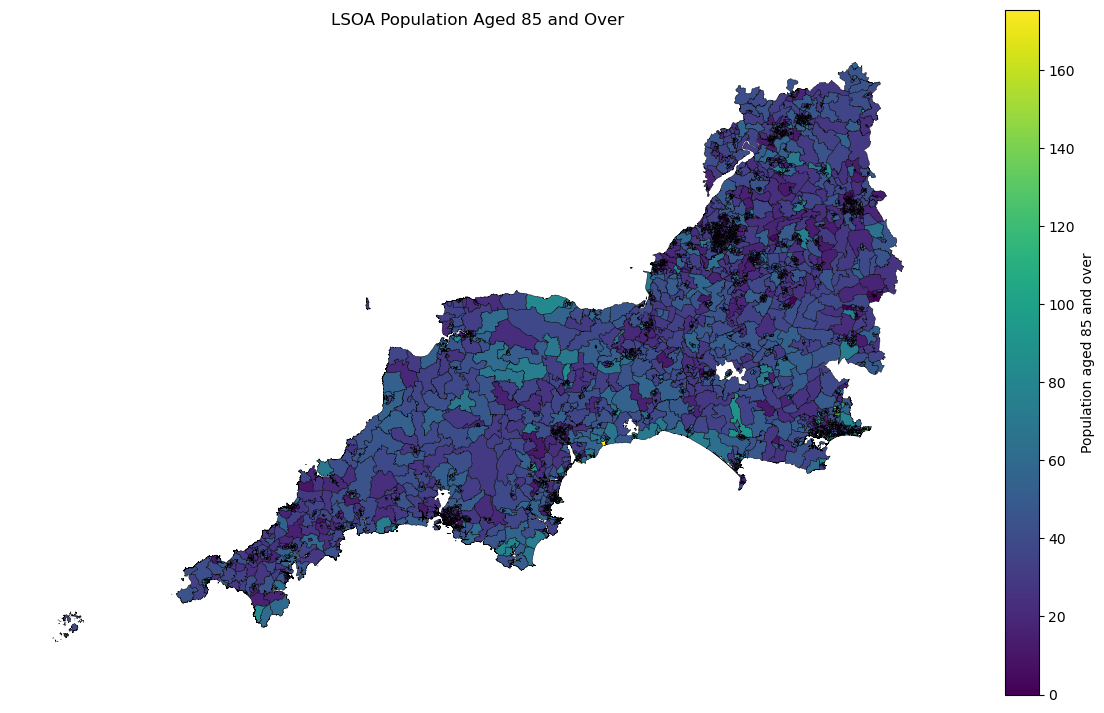

In [10]:
# ------------------------------------------------------------
# Visualise LSOA by Population Aged 85 and Over
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# Step 1: Sum ages 85 to 89 into a new column
gdf_lsoa_age["85_and_over"] = gdf_lsoa_age[[str(age) for age in range(85, 90)]].sum(axis=1)

# Step 2: Plot the map
fig, ax = plt.subplots(figsize=(12, 14))
gdf_lsoa_age.plot(
    column="85_and_over",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Population aged 85 and over", "shrink": 0.5},
    ax=ax,
    edgecolor="black",
    linewidth=0.3
)
ax.set_title("LSOA Population Aged 85 and Over")
ax.axis("off")
plt.tight_layout()
plt.show()
